# Embedding Pooling Strategy Analysis


### Setup


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv

load_dotenv()


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### Load Embedding Data


In [2]:
DATA_DIR = os.getenv("INFLAMM_DEBATE_FM_DATA_ROOT")

# fallback to default
if DATA_DIR is None:
    DATA_DIR = "../data/"

EMBEDDINGS_BASE_DIR = Path(DATA_DIR) / "processed" / "bulkformer_embeddings"

# Define the three configurations
configs = {
    "human_only": EMBEDDINGS_BASE_DIR / "human_only",
    "mouse_only": EMBEDDINGS_BASE_DIR / "mouse_only",
    "human_ortholog_filtered": EMBEDDINGS_BASE_DIR / "human_ortholog_filtered",
}

# Check which configurations exist
available_configs = {k: v for k, v in configs.items() if v.exists()}
print(f"Available configurations: {list(available_configs.keys())}")

# List available embedding files in each config
for config_name, config_dir in available_configs.items():
    print(f"\n{config_name}:")
    npy_files = sorted(config_dir.glob("*.npy"))
    for f in npy_files:
        print(f"  - {f.name}")


Available configurations: ['human_only', 'mouse_only', 'human_ortholog_filtered']

human_only:
  - human_burn_human_only_embeddings.npy
  - human_sepsis_human_only_embeddings.npy
  - human_trauma_human_only_embeddings.npy

mouse_only:
  - mouse_burn_mouse_only_embeddings.npy
  - mouse_infection_mouse_only_embeddings.npy
  - mouse_sepsis_mouse_only_embeddings.npy
  - mouse_trauma_mouse_only_embeddings.npy

human_ortholog_filtered:
  - human_burn_human_ortholog_filtered_embeddings.npy
  - human_sepsis_human_ortholog_filtered_embeddings.npy
  - human_trauma_human_ortholog_filtered_embeddings.npy


### Helper Functions for Memory-Efficient Loading


In [3]:
def load_metadata_for_embeddings(embedding_path: Path):
    """
    Load metadata to identify control and inflammation samples.
    Assumes metadata is stored alongside embeddings or can be inferred from AnnData.
    For now, we'll need to load the corresponding AnnData to get sample labels.
    """
    # Extract dataset name from embedding filename
    # Format: {dataset}_transcriptome_embeddings.npy
    dataset_name = embedding_path.stem.split("_")[0] + "_" + embedding_path.stem.split("_")[1]
    
    # Load corresponding AnnData to get metadata
    ann_data_dir = Path(DATA_DIR) / "processed" / "anndata_cleaned"
    ann_data_path = ann_data_dir / f"{dataset_name}.h5ad"
    
    if ann_data_path.exists():
        import anndata as ad
        adata = ad.read_h5ad(ann_data_path)
        return adata.obs
    else:
        print(f"Warning: Could not find AnnData for {dataset_name}")
        return None


def get_sample_indices(metadata, n_samples_per_group=15):
    """
    Get indices for control and inflammation samples.
    Assumes metadata has a column indicating control/inflammation status.
    """
    # Try common column names for status
    status_cols = ["takao_status", "status", "condition", "group", "inflammation"]
    status_col = None
    for col in status_cols:
        if col in metadata.columns:
            status_col = col
            break
    
    if status_col is None:
        print(f"Warning: Could not find status column. Available: {metadata.columns.tolist()}")
        # Return first n_samples_per_group*2 samples as fallback
        return np.arange(n_samples_per_group * 2)
    
    # Get control and inflammation indices
    if "control" in status_col.lower() or "takao" in status_col.lower():
        # Handle takao_status format
        control_mask = metadata[status_col].str.contains("control", case=False, na=False)
        inflam_mask = metadata[status_col].str.contains("inflam", case=False, na=False)
    else:
        # Generic handling
        unique_vals = metadata[status_col].unique()
        if len(unique_vals) >= 2:
            control_mask = metadata[status_col] == unique_vals[0]
            inflam_mask = metadata[status_col] == unique_vals[1]
        else:
            # Fallback: split by index
            n_total = len(metadata)
            return np.arange(min(n_samples_per_group * 2, n_total))
    
    control_indices = np.where(control_mask)[0]
    inflam_indices = np.where(inflam_mask)[0]
    
    # Sample up to n_samples_per_group from each
    n_control = min(n_samples_per_group, len(control_indices))
    n_inflam = min(n_samples_per_group, len(inflam_indices))
    
    selected_control = np.random.choice(control_indices, size=n_control, replace=False)
    selected_inflam = np.random.choice(inflam_indices, size=n_inflam, replace=False)
    
    return np.sort(np.concatenate([selected_control, selected_inflam]))


def load_embeddings_subset(embedding_path: Path, sample_indices: np.ndarray):
    """
    Load a subset of embeddings without loading the full array into memory.
    Uses memory mapping for large files.
    """
    # Use memory mapping to avoid loading full array
    mmap_emb = np.load(embedding_path, mmap_mode='r')
    
    # Load only the selected samples
    if len(sample_indices) > 0:
        embeddings = mmap_emb[sample_indices]
    else:
        embeddings = mmap_emb[:]
    
    return embeddings


### Load Embeddings with Sample Limiting


In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Load embeddings for each configuration
embeddings_data = {}

for config_name, config_dir in available_configs.items():
    print(f"\n{'='*60}")
    print(f"Processing: {config_name}")
    print(f"{'='*60}")
    
    config_embeddings = {}
    npy_files = sorted(config_dir.glob("*.npy"))
    
    for emb_file in npy_files:
        dataset_name = emb_file.stem.replace("_transcriptome_embeddings", "")
        print(f"\n  Dataset: {dataset_name}")
        
        # Load metadata to identify samples
        metadata = load_metadata_for_embeddings(emb_file)
        
        if metadata is not None:
            # Get sample indices (15 control + 15 inflammation)
            sample_indices = get_sample_indices(metadata, n_samples_per_group=15)
            print(f"    Selected {len(sample_indices)} samples")
            
            # Load embeddings subset
            emb_subset = load_embeddings_subset(emb_file, sample_indices)
            print(f"    Embedding shape: {emb_subset.shape}")
            
            config_embeddings[dataset_name] = {
                "embeddings": emb_subset,
                "sample_indices": sample_indices,
                "metadata": metadata.iloc[sample_indices] if metadata is not None else None
            }
        else:
            # Fallback: load first 30 samples
            print(f"    Warning: Loading first 30 samples (no metadata found)")
            emb_subset = load_embeddings_subset(emb_file, np.arange(30))
            config_embeddings[dataset_name] = {
                "embeddings": emb_subset,
                "sample_indices": np.arange(30),
                "metadata": None
            }
    
    embeddings_data[config_name] = config_embeddings

print(f"\n{'='*60}")
print("Loading complete!")
print(f"{'='*60}")



Processing: human_only

  Dataset: human_burn_human_only_embeddings
    Selected 30 samples
    Embedding shape: (30, 20010, 640)

  Dataset: human_sepsis_human_only_embeddings
    Selected 25 samples
    Embedding shape: (25, 20010, 640)

  Dataset: human_trauma_human_only_embeddings
    Selected 30 samples
    Embedding shape: (30, 20010, 640)

Processing: mouse_only

  Dataset: mouse_burn_mouse_only_embeddings
    Selected 19 samples
    Embedding shape: (19, 20010, 640)

  Dataset: mouse_infection_mouse_only_embeddings
    Selected 29 samples
    Embedding shape: (29, 20010, 640)

  Dataset: mouse_sepsis_mouse_only_embeddings
    Selected 10 samples
    Embedding shape: (10, 20010, 640)

  Dataset: mouse_trauma_mouse_only_embeddings
    Selected 27 samples
    Embedding shape: (27, 20010, 640)

Processing: human_ortholog_filtered

  Dataset: human_burn_human_ortholog_filtered_embeddings
    Selected 30 samples
    Embedding shape: (30, 20010, 640)

  Dataset: human_sepsis_human_or

### Variance Analysis: Full Embeddings


In [12]:
def compute_variance_per_gene(embeddings):
    """
    Compute variance per gene across samples.
    embeddings: (n_samples, n_genes, embedding_dim) or (n_samples, n_features)
    """
    if len(embeddings.shape) == 3:
        # (n_samples, n_genes, embedding_dim) - need to pool first or compute per gene
        # For now, flatten gene and embedding dimensions
        n_samples, n_genes, emb_dim = embeddings.shape
        # Reshape to (n_samples, n_genes * emb_dim) for variance calculation
        embeddings_flat = embeddings.reshape(n_samples, -1)
        # Variance across samples (axis=0)
        var_per_feature = np.var(embeddings_flat, axis=0)
        # Reshape back to (n_genes, emb_dim) to get variance per gene
        var_per_gene_emb = var_per_feature.reshape(n_genes, emb_dim)
        # Average variance across embedding dimensions per gene
        var_per_gene = np.mean(var_per_gene_emb, axis=1)
        return var_per_gene, var_per_gene_emb

def compute_pca_variance(embeddings, n_components=50):
    """
    Compute PCA and return explained variance.
    """
    # Flatten if 3D
    if len(embeddings.shape) == 3:
        n_samples, n_genes, emb_dim = embeddings.shape
        embeddings_flat = embeddings.reshape(n_samples, -1)
    else:
        # Already 2D, use directly
        embeddings_flat = embeddings
    
    # Standardize
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_flat)
    
    # PCA
    pca = PCA(n_components=min(n_components, embeddings_scaled.shape[1], embeddings_scaled.shape[0]-1))
    pca.fit(embeddings_scaled)
    
    return {
        "explained_variance_ratio": pca.explained_variance_ratio_,
        "explained_variance": pca.explained_variance_,
        "cumulative_variance": np.cumsum(pca.explained_variance_ratio_),
        "n_components": len(pca.explained_variance_ratio_)
    }


In [13]:
# Analyze variance for each configuration
variance_results = {}

for config_name, config_data in embeddings_data.items():
    print(f"\n{'='*60}")
    print(f"Variance Analysis: {config_name}")
    print(f"{'='*60}")
    
    config_results = {}
    
    for dataset_name, data in config_data.items():
        embeddings = data["embeddings"]
        print(f"\n  Dataset: {dataset_name}")
        print(f"    Shape: {embeddings.shape}")
        
        # Compute variance per gene
        var_per_gene, var_per_gene_emb = compute_variance_per_gene(embeddings)
        print(f"    Variance per gene shape: {var_per_gene.shape}")
        print(f"    Mean variance: {np.mean(var_per_gene):.4f}")
        print(f"    Std variance: {np.std(var_per_gene):.4f}")
        
        # Compute PCA variance
        pca_results = compute_pca_variance(embeddings, n_components=50)
        print(f"    PCA components: {pca_results['n_components']}")
        if len(pca_results['explained_variance_ratio']) >= 5:
            print(f"    First 5 PC explained variance: {pca_results['explained_variance_ratio'][:5]}")
        if len(pca_results['cumulative_variance']) >= 10:
            print(f"    Cumulative variance (first 10 PCs): {pca_results['cumulative_variance'][9]:.4f}")
        
        config_results[dataset_name] = {
            "var_per_gene": var_per_gene,
            "var_per_gene_emb": var_per_gene_emb,
            "pca_results": pca_results,
            "embeddings_shape": embeddings.shape
        }
    
    variance_results[config_name] = config_results



Variance Analysis: human_only

  Dataset: human_burn_human_only_embeddings
    Shape: (30, 20010, 640)
    Variance per gene shape: (20010,)
    Mean variance: 0.0117
    Std variance: 0.0132
    PCA components: 29
    First 5 PC explained variance: [0.24378401 0.23014233 0.14237289 0.10704596 0.03526307]
    Cumulative variance (first 10 PCs): 0.8577

  Dataset: human_sepsis_human_only_embeddings
    Shape: (25, 20010, 640)
    Variance per gene shape: (20010,)
    Mean variance: 0.0076
    Std variance: 0.0115
    PCA components: 24
    First 5 PC explained variance: [0.30083057 0.27213502 0.08543887 0.05705919 0.03411927]
    Cumulative variance (first 10 PCs): 0.8668

  Dataset: human_trauma_human_only_embeddings
    Shape: (30, 20010, 640)
    Variance per gene shape: (20010,)
    Mean variance: 0.0092
    Std variance: 0.0127
    PCA components: 29
    First 5 PC explained variance: [0.3749455  0.16153955 0.08046852 0.06800105 0.0495135 ]
    Cumulative variance (first 10 PCs): 

### Pooling Strategies


In [14]:
def mean_pooling(embeddings):
    """
    Mean pooling along gene dimension.
    embeddings: (n_samples, n_genes, embedding_dim)
    returns: (n_samples, embedding_dim)
    """
    if len(embeddings.shape) == 3:
        return np.mean(embeddings, axis=1)
    else:
        return embeddings  # Already pooled or 2D


def max_pooling(embeddings):
    """
    Max pooling along gene dimension.
    embeddings: (n_samples, n_genes, embedding_dim)
    returns: (n_samples, embedding_dim)
    """
    if len(embeddings.shape) == 3:
        return np.max(embeddings, axis=1)
    else:
        return embeddings  # Already pooled or 2D


def sum_pooling(embeddings):
    """
    Sum pooling along gene dimension.
    embeddings: (n_samples, n_genes, embedding_dim)
    returns: (n_samples, embedding_dim)
    """
    if len(embeddings.shape) == 3:
        return np.sum(embeddings, axis=1)
    else:
        return embeddings  # Already pooled or 2D


def apply_pooling_strategies(embeddings):
    """
    Apply all pooling strategies to embeddings.
    """
    results = {}
    
    if len(embeddings.shape) == 3:
        results["mean"] = mean_pooling(embeddings)
        results["max"] = max_pooling(embeddings)
        results["sum"] = sum_pooling(embeddings)
    else:
        # Already 2D, assume it's already pooled somehow
        results["original"] = embeddings
    
    return results


In [15]:
# Apply pooling strategies to all embeddings
pooling_results = {}

for config_name, config_data in embeddings_data.items():
    print(f"\n{'='*60}")
    print(f"Pooling Analysis: {config_name}")
    print(f"{'='*60}")
    
    config_pooling = {}
    
    for dataset_name, data in config_data.items():
        embeddings = data["embeddings"]
        print(f"\n  Dataset: {dataset_name}")
        print(f"    Original shape: {embeddings.shape}")
        
        pooled = apply_pooling_strategies(embeddings)
        
        for strategy, pooled_emb in pooled.items():
            print(f"    {strategy} pooling shape: {pooled_emb.shape}")
        
        config_pooling[dataset_name] = {
            "original": embeddings,
            "pooled": pooled
        }
    
    pooling_results[config_name] = config_pooling



Pooling Analysis: human_only

  Dataset: human_burn_human_only_embeddings
    Original shape: (30, 20010, 640)
    mean pooling shape: (30, 640)
    max pooling shape: (30, 640)
    sum pooling shape: (30, 640)

  Dataset: human_sepsis_human_only_embeddings
    Original shape: (25, 20010, 640)
    mean pooling shape: (25, 640)
    max pooling shape: (25, 640)
    sum pooling shape: (25, 640)

  Dataset: human_trauma_human_only_embeddings
    Original shape: (30, 20010, 640)
    mean pooling shape: (30, 640)
    max pooling shape: (30, 640)
    sum pooling shape: (30, 640)

Pooling Analysis: mouse_only

  Dataset: mouse_burn_mouse_only_embeddings
    Original shape: (19, 20010, 640)
    mean pooling shape: (19, 640)
    max pooling shape: (19, 640)
    sum pooling shape: (19, 640)

  Dataset: mouse_infection_mouse_only_embeddings
    Original shape: (29, 20010, 640)
    mean pooling shape: (29, 640)
    max pooling shape: (29, 640)
    sum pooling shape: (29, 640)

  Dataset: mouse_sep

### Visualization: PCA Variance Explained


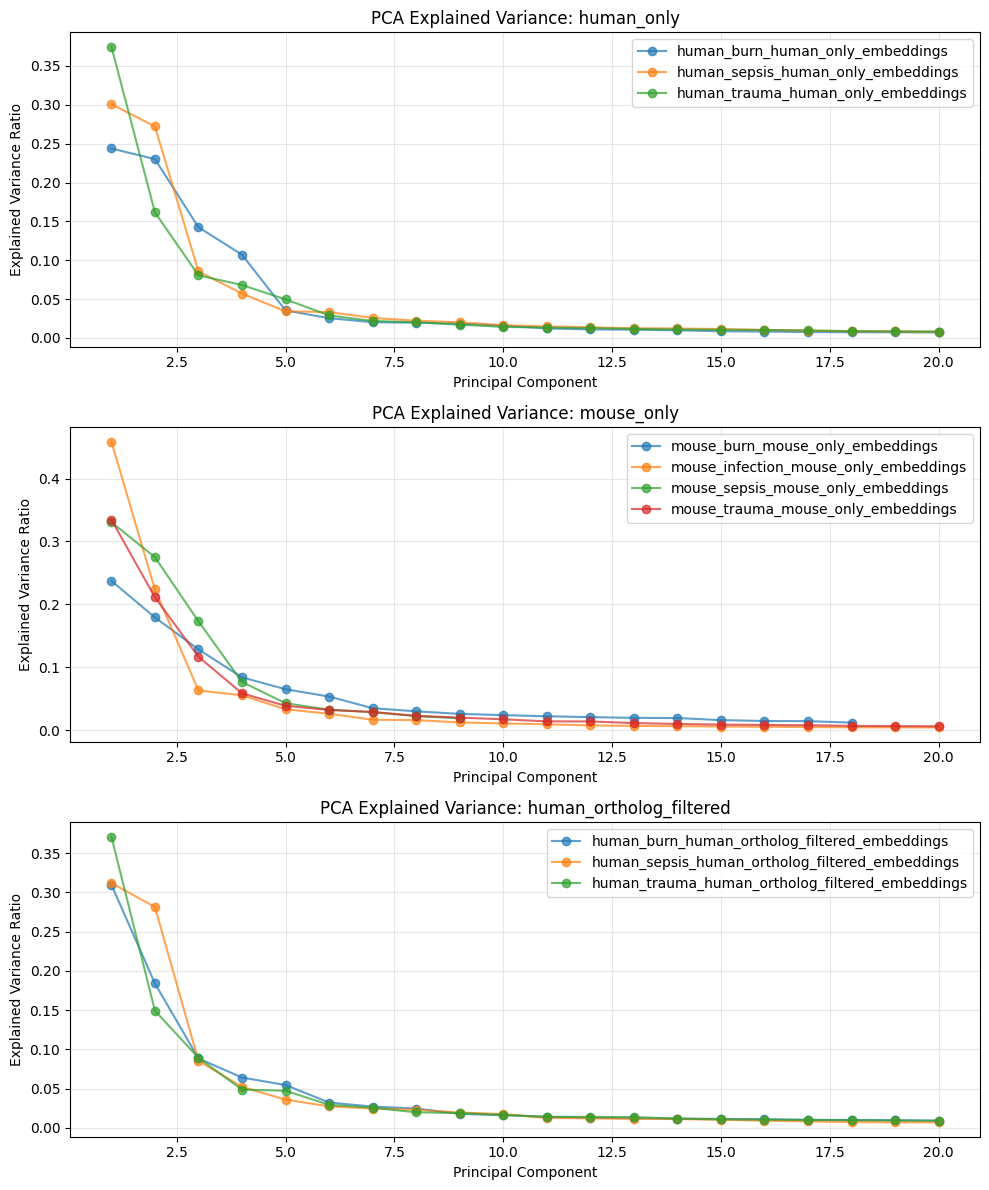

In [16]:
# Plot PCA explained variance for full embeddings
fig, axes = plt.subplots(len(available_configs), 1, figsize=(10, 4*len(available_configs)))
if len(available_configs) == 1:
    axes = [axes]

for idx, (config_name, config_results) in enumerate(variance_results.items()):
    ax = axes[idx]
    
    for dataset_name, results in config_results.items():
        pca_res = results["pca_results"]
        n_components = pca_res["n_components"]
        x = np.arange(1, min(21, n_components + 1))  # First 20 components
        
        ax.plot(x, pca_res["explained_variance_ratio"][:len(x)], 
                marker='o', label=dataset_name, alpha=0.7)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance Ratio")
    ax.set_title(f"PCA Explained Variance: {config_name}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Visualization: Variance per Gene


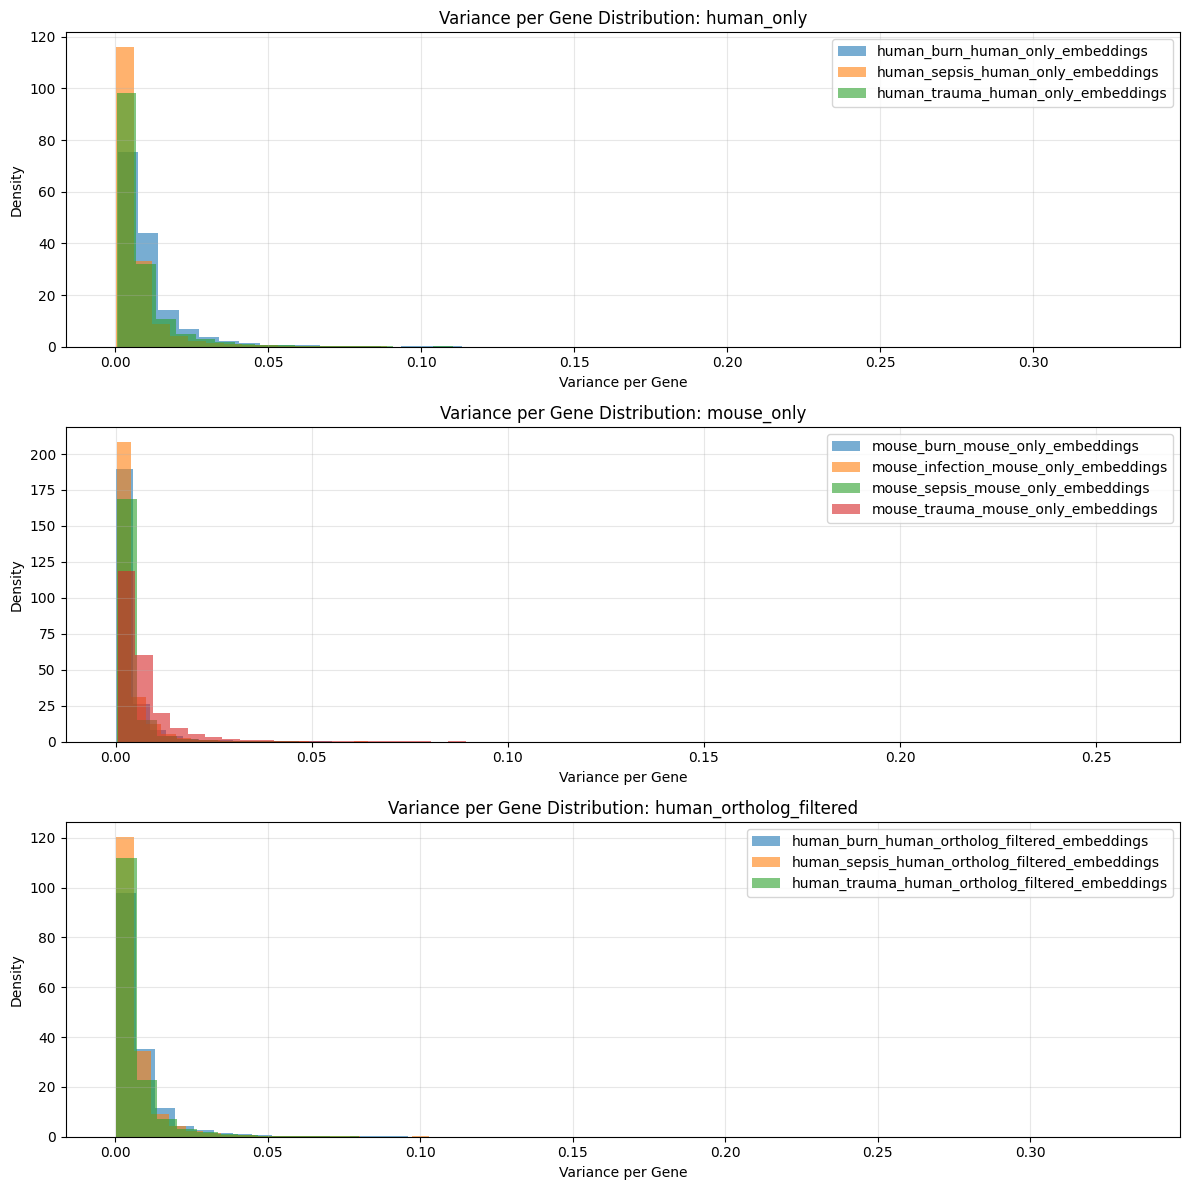

In [17]:
# Plot variance per gene distribution
fig, axes = plt.subplots(len(available_configs), 1, figsize=(12, 4*len(available_configs)))
if len(available_configs) == 1:
    axes = [axes]

for idx, (config_name, config_results) in enumerate(variance_results.items()):
    ax = axes[idx]
    
    for dataset_name, results in config_results.items():
        var_per_gene = results["var_per_gene"]
        ax.hist(var_per_gene, bins=50, alpha=0.6, label=dataset_name, density=True)
    
    ax.set_xlabel("Variance per Gene")
    ax.set_ylabel("Density")
    ax.set_title(f"Variance per Gene Distribution: {config_name}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Visualization: Pooling Strategy Comparison



Pooling Strategy Comparison: human_only


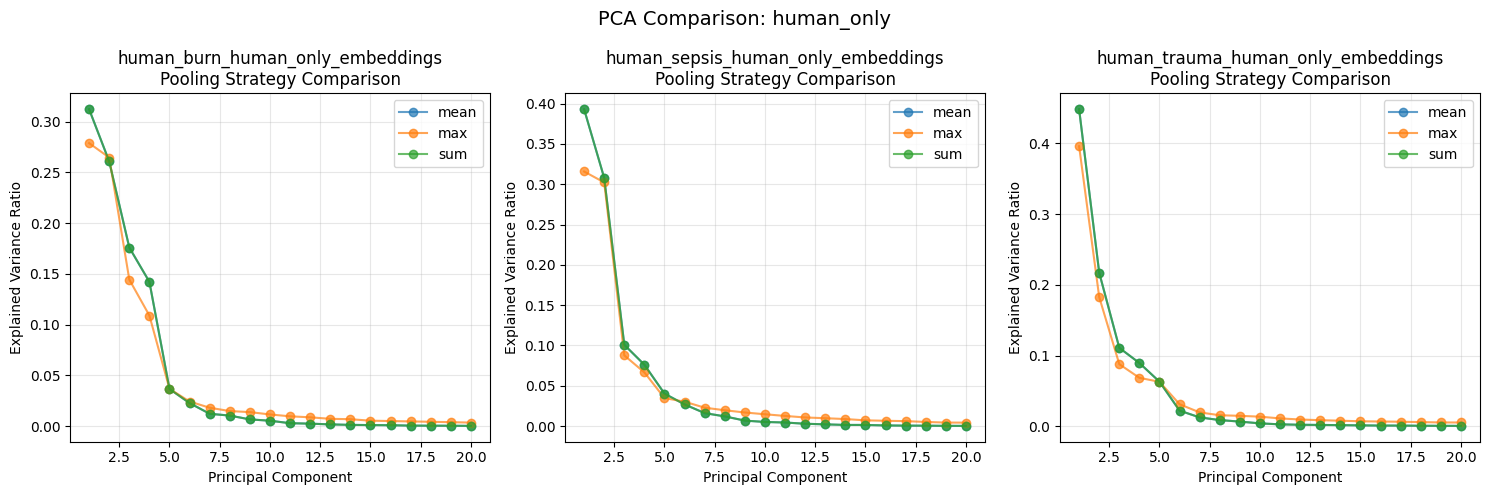


Pooling Strategy Comparison: mouse_only


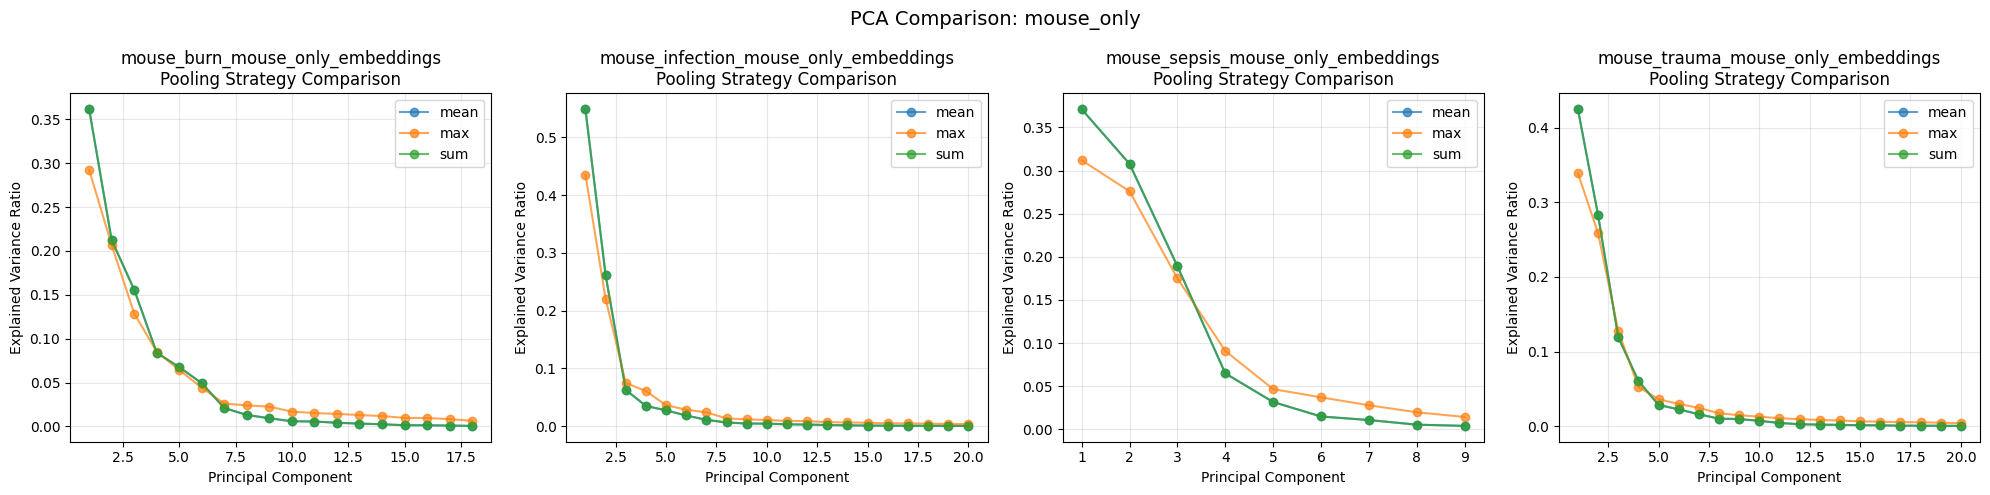


Pooling Strategy Comparison: human_ortholog_filtered


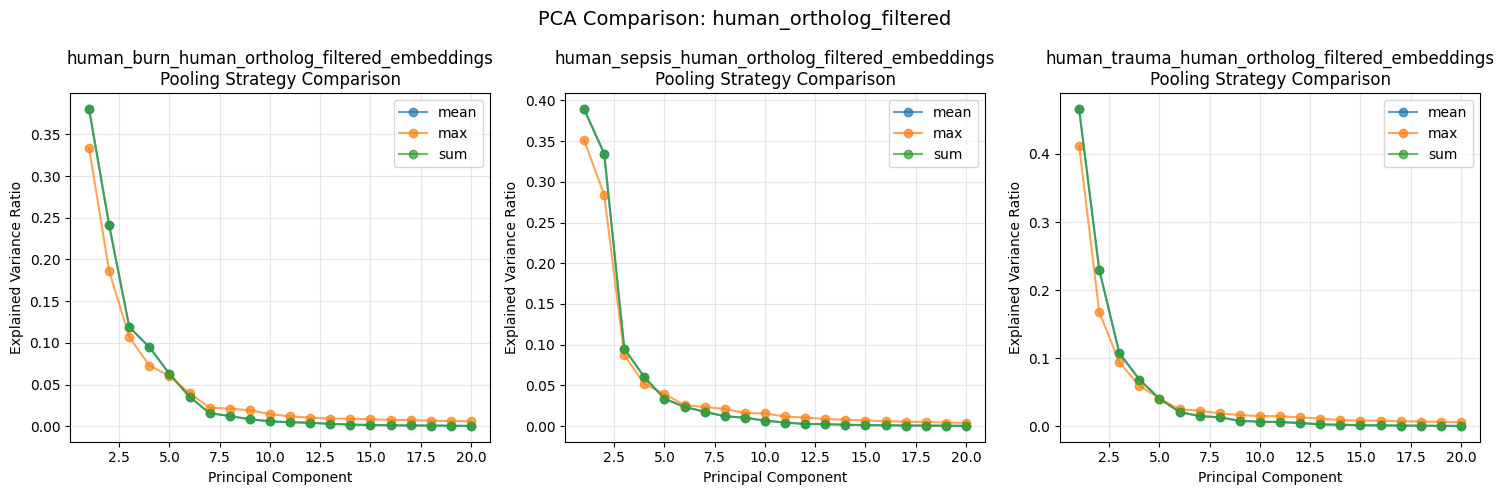

In [18]:
# Compare pooling strategies using PCA on pooled embeddings
for config_name, config_pooling in pooling_results.items():
    print(f"\n{'='*60}")
    print(f"Pooling Strategy Comparison: {config_name}")
    print(f"{'='*60}")
    
    # Compute PCA for each pooling strategy
    pooling_pca_results = {}
    
    for dataset_name, data in config_pooling.items():
        dataset_pca = {}
        
        for strategy, pooled_emb in data["pooled"].items():
            if len(pooled_emb.shape) == 2 and pooled_emb.shape[1] > 1:
                pca_res = compute_pca_variance(pooled_emb, n_components=20)
                dataset_pca[strategy] = pca_res
        
        pooling_pca_results[dataset_name] = dataset_pca
    
    # Plot comparison
    n_datasets = len(config_pooling)
    fig, axes = plt.subplots(1, n_datasets, figsize=(5*n_datasets, 5))
    if n_datasets == 1:
        axes = [axes]
    
    for ax, (dataset_name, dataset_pca) in zip(axes, pooling_pca_results.items()):
        for strategy, pca_res in dataset_pca.items():
            n_comp = min(20, pca_res["n_components"])
            x = np.arange(1, n_comp + 1)
            ax.plot(x, pca_res["explained_variance_ratio"][:n_comp], 
                   marker='o', label=strategy, alpha=0.7)
        
        ax.set_xlabel("Principal Component")
        ax.set_ylabel("Explained Variance Ratio")
        ax.set_title(f"{dataset_name}\nPooling Strategy Comparison")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"PCA Comparison: {config_name}", fontsize=14)
    plt.tight_layout()
    plt.show()


### Visualization: UMAP Clustering for Pooling Strategies



UMAP Clustering: human_only


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


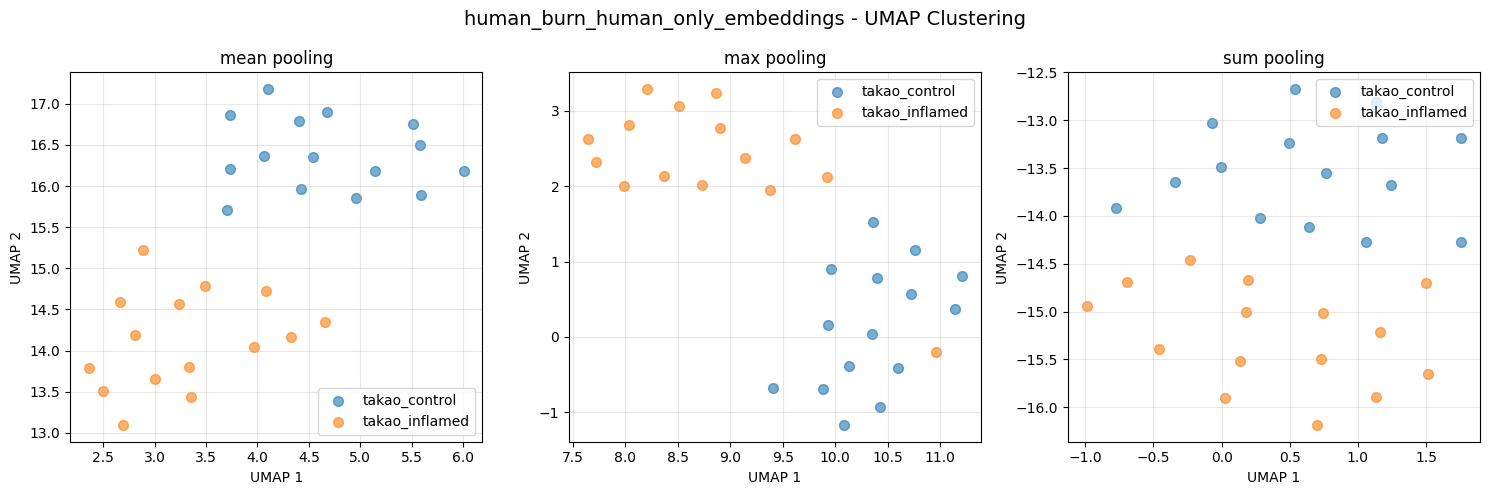

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


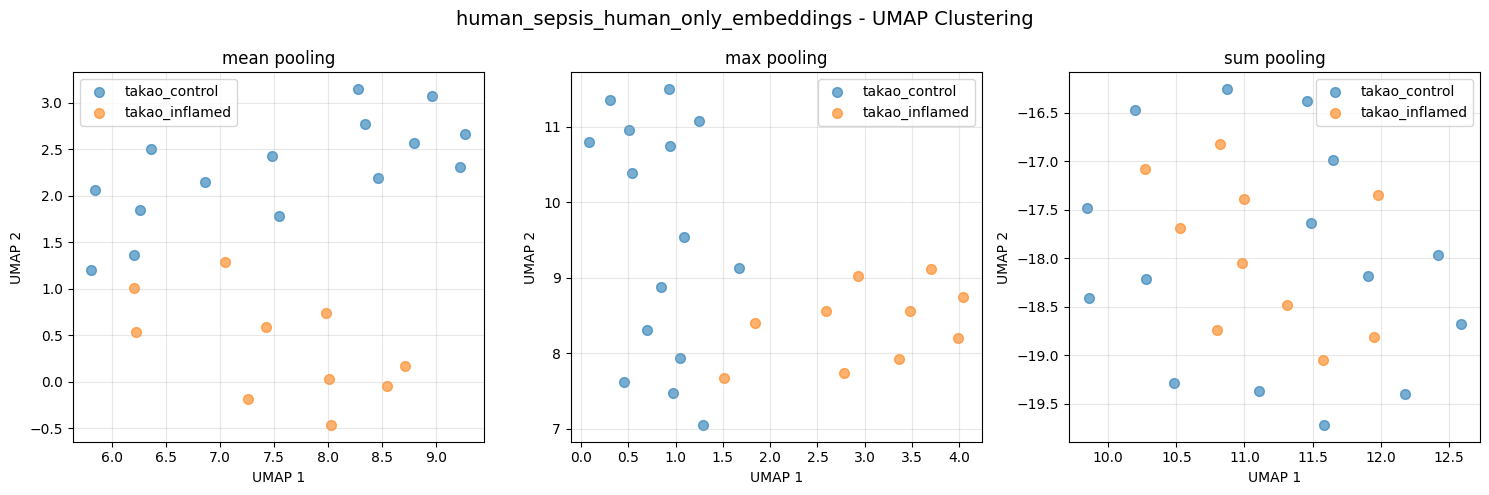

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


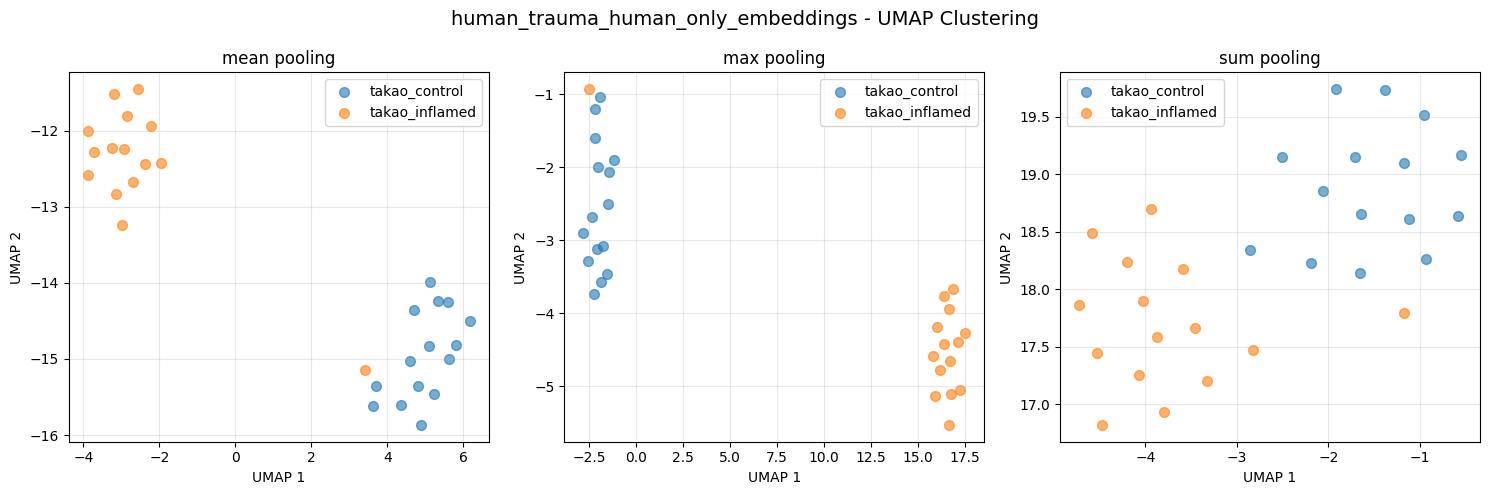


UMAP Clustering: mouse_only


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


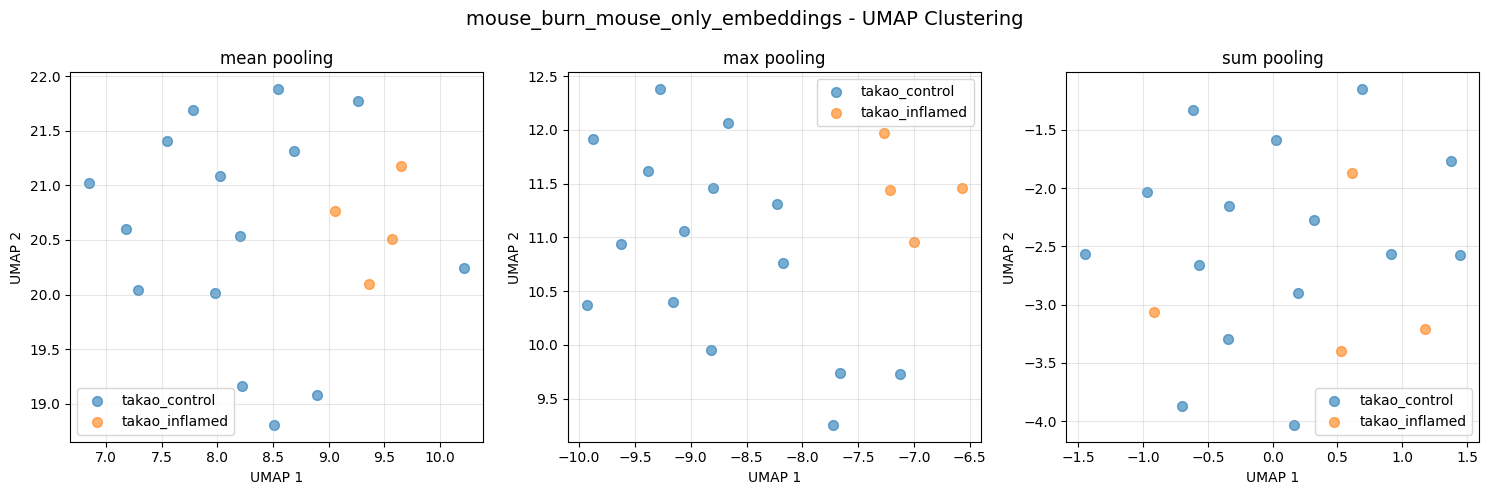

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


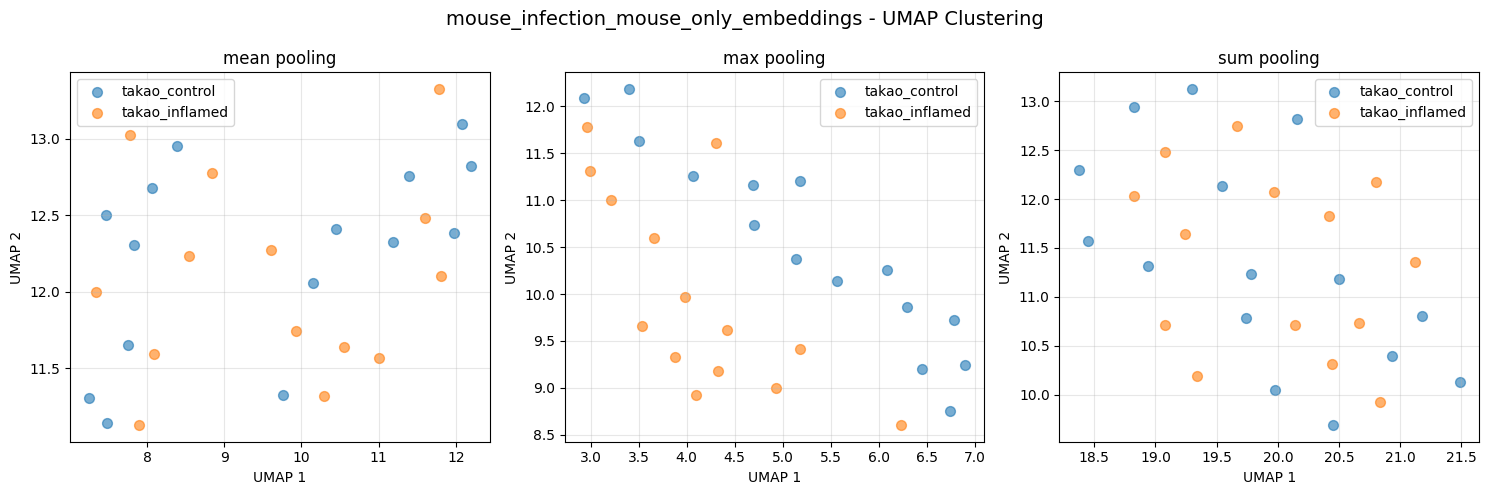

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


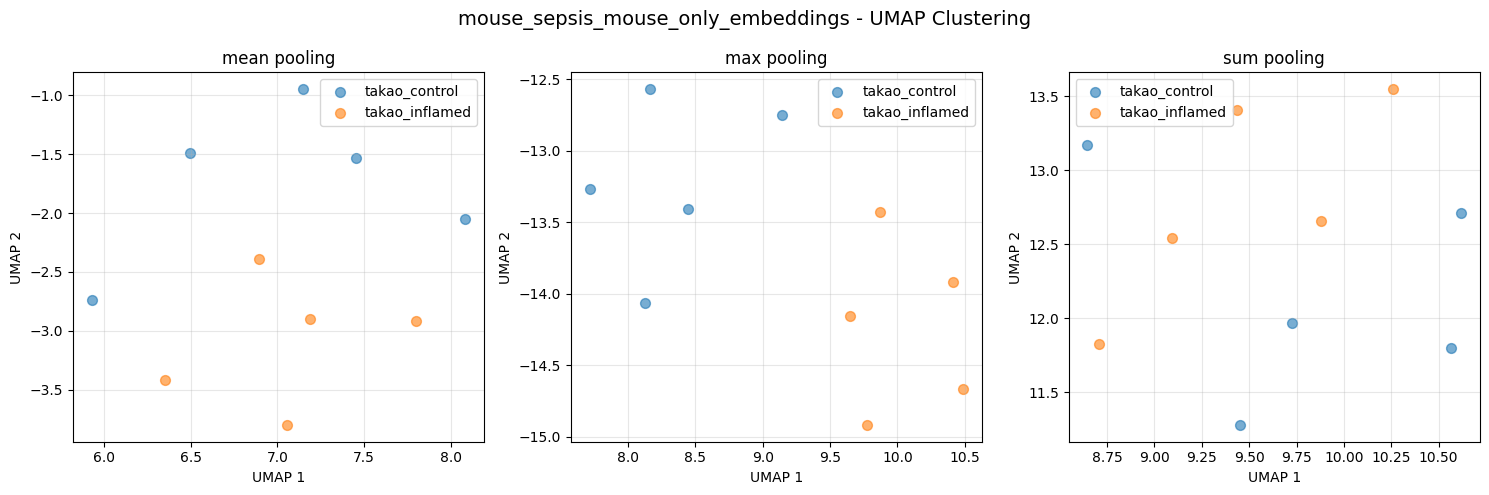

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


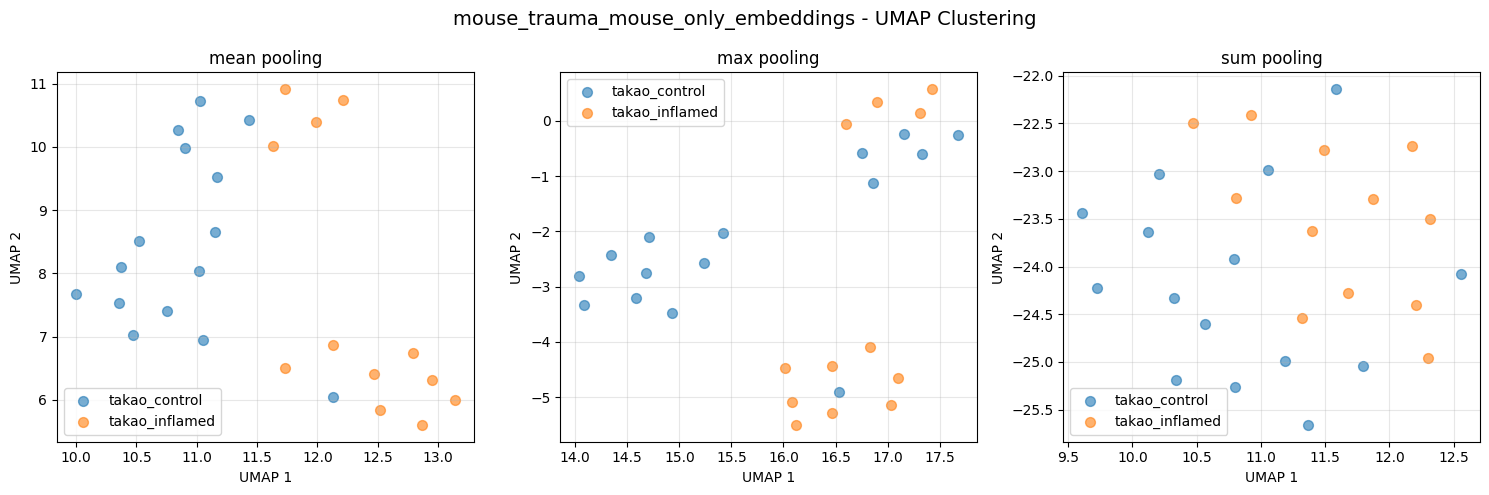


UMAP Clustering: human_ortholog_filtered


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


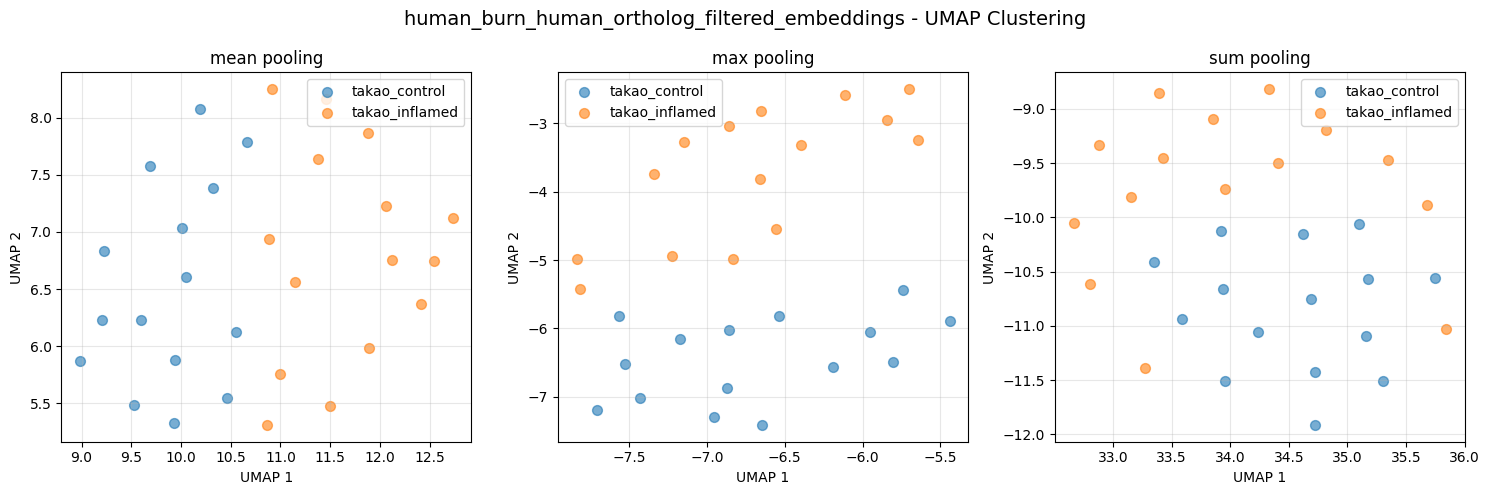

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


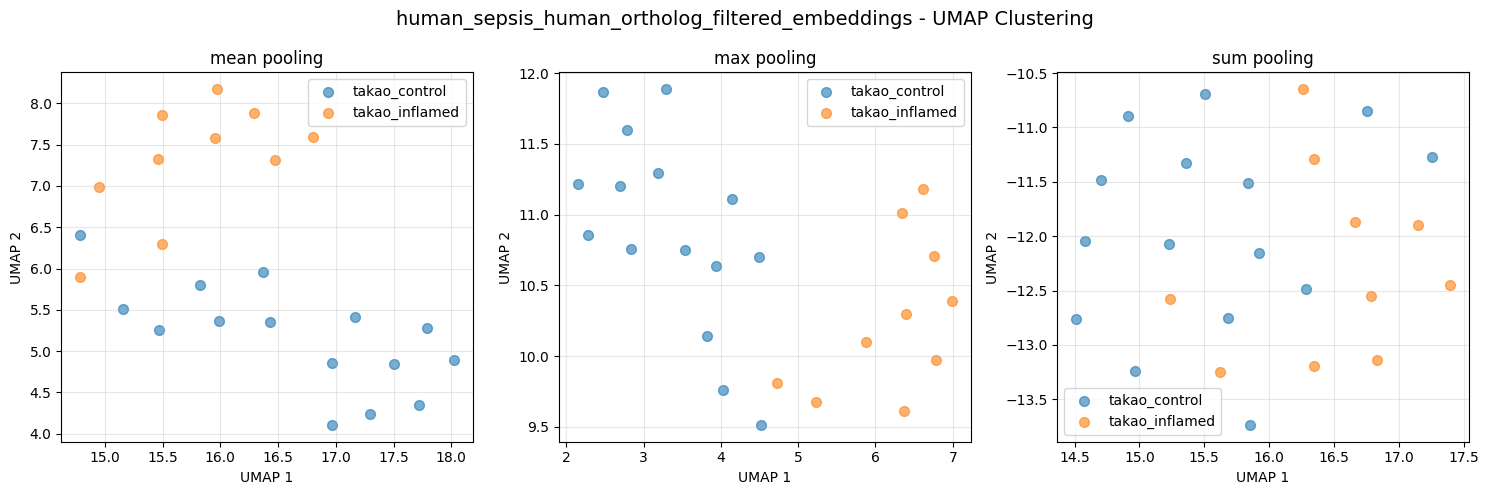

/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


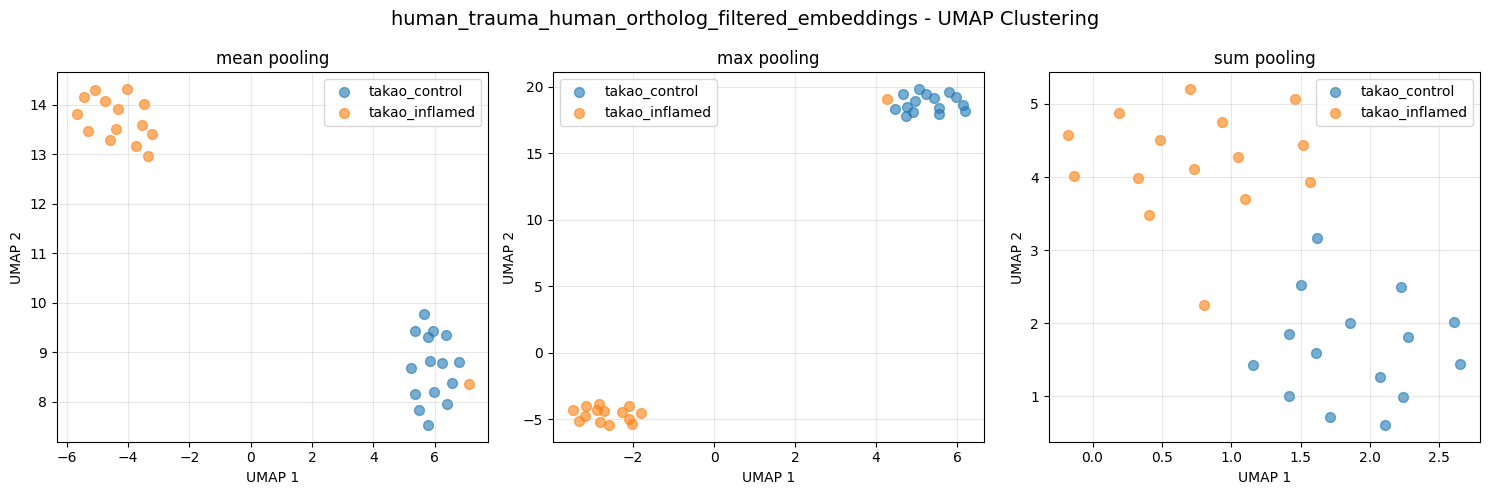

In [19]:
# UMAP visualization for each pooling strategy
for config_name, config_pooling in pooling_results.items():
    print(f"\n{'='*60}")
    print(f"UMAP Clustering: {config_name}")
    print(f"{'='*60}")
    
    for dataset_name, data in config_pooling.items():
        metadata = embeddings_data[config_name][dataset_name]["metadata"]
        
        # Get status labels if available
        if metadata is not None:
            status_cols = ["takao_status", "status", "condition", "group"]
            status_col = None
            for col in status_cols:
                if col in metadata.columns:
                    status_col = col
                    break
            
            if status_col:
                labels = metadata[status_col].values
            else:
                labels = None
        else:
            labels = None
        
        # Plot UMAP for each pooling strategy
        n_strategies = len([s for s in data["pooled"].keys() if len(data["pooled"][s].shape) == 2])
        fig, axes = plt.subplots(1, n_strategies, figsize=(5*n_strategies, 5))
        if n_strategies == 1:
            axes = [axes]
        
        ax_idx = 0
        for strategy, pooled_emb in data["pooled"].items():
            if len(pooled_emb.shape) == 2 and pooled_emb.shape[1] > 2:
                reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(pooled_emb)-1))
                embedding_2d = reducer.fit_transform(pooled_emb)
                
                ax = axes[ax_idx]
                if labels is not None:
                    unique_labels = np.unique(labels)
                    for label in unique_labels:
                        mask = labels == label
                        ax.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                                 label=str(label), alpha=0.6, s=50)
                    ax.legend()
                else:
                    ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.6, s=50)
                
                ax.set_xlabel("UMAP 1")
                ax.set_ylabel("UMAP 2")
                ax.set_title(f"{strategy} pooling")
                ax.grid(True, alpha=0.3)
                ax_idx += 1
        
        plt.suptitle(f"{dataset_name} - UMAP Clustering", fontsize=14)
        plt.tight_layout()
        plt.show()



UMAP Clustering (High-Variance Genes Only): human_only

  Dataset: human_burn_human_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0226 - 0.3315


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


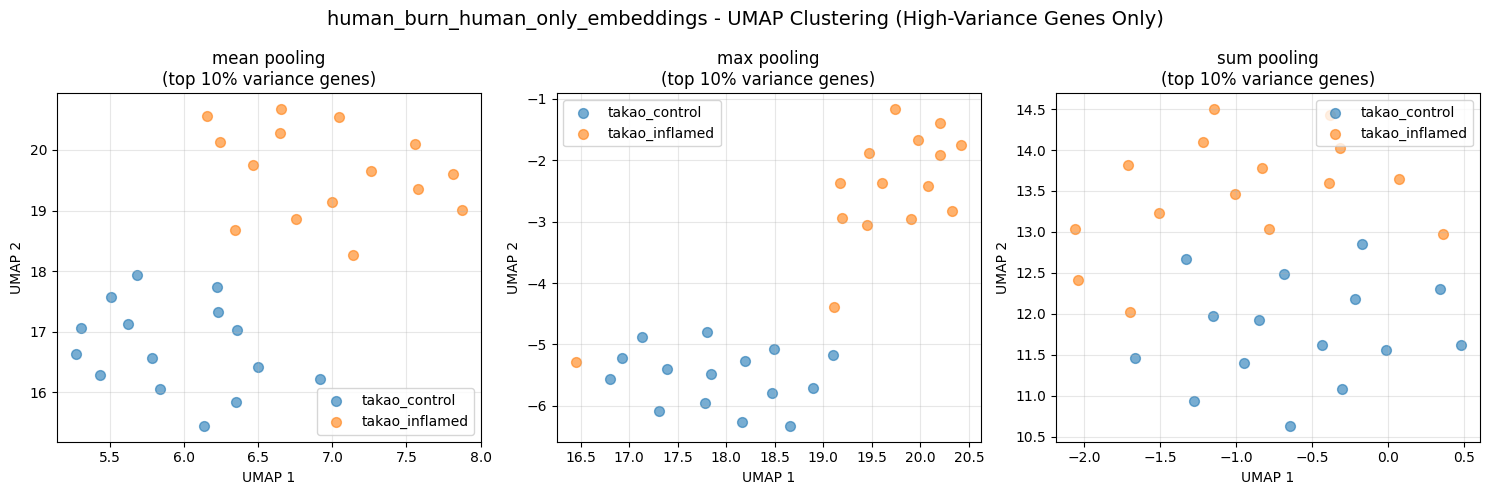


  Dataset: human_sepsis_human_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0142 - 0.2948


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


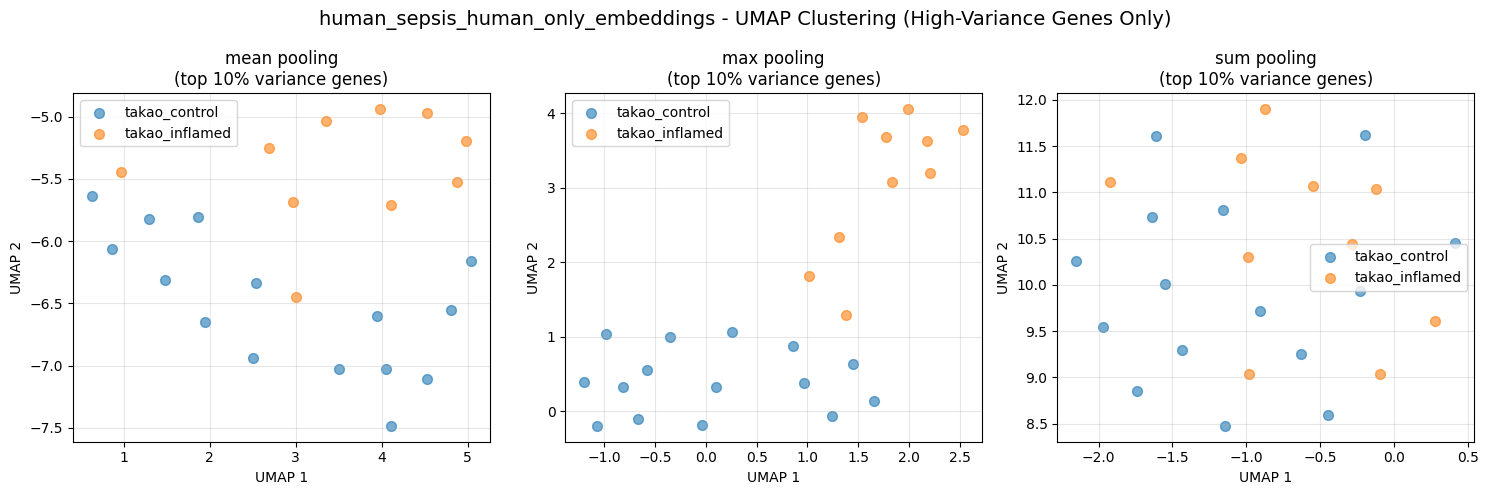


  Dataset: human_trauma_human_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0183 - 0.3237


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


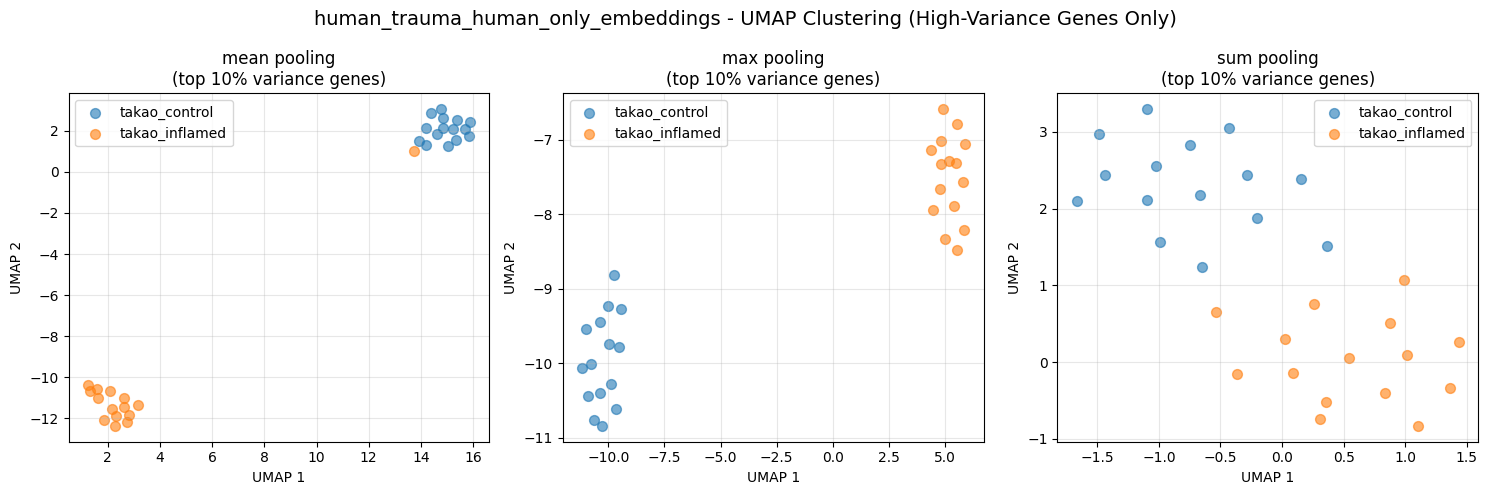


UMAP Clustering (High-Variance Genes Only): mouse_only

  Dataset: mouse_burn_mouse_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0077 - 0.2120


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


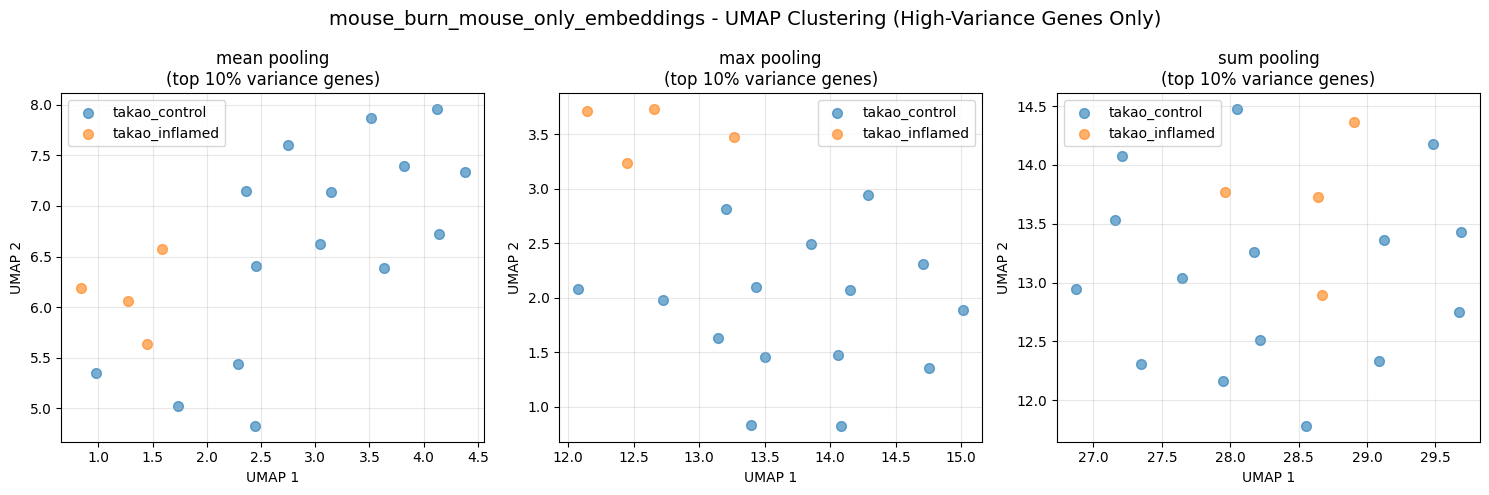


  Dataset: mouse_infection_mouse_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0077 - 0.1891


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


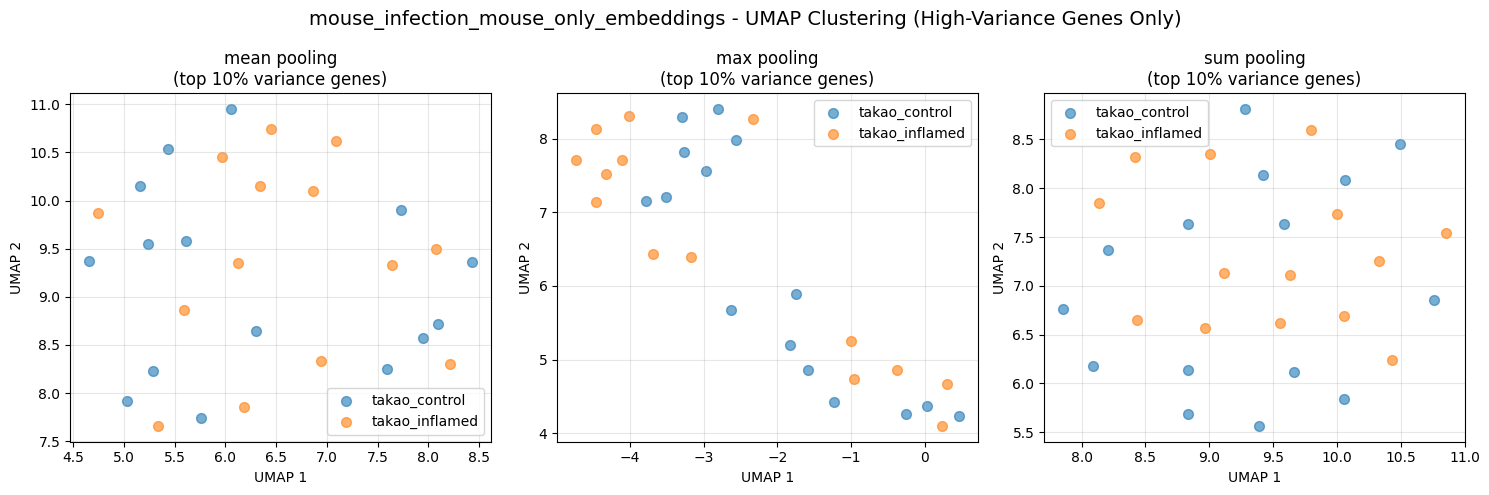


  Dataset: mouse_sepsis_mouse_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0064 - 0.2584


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


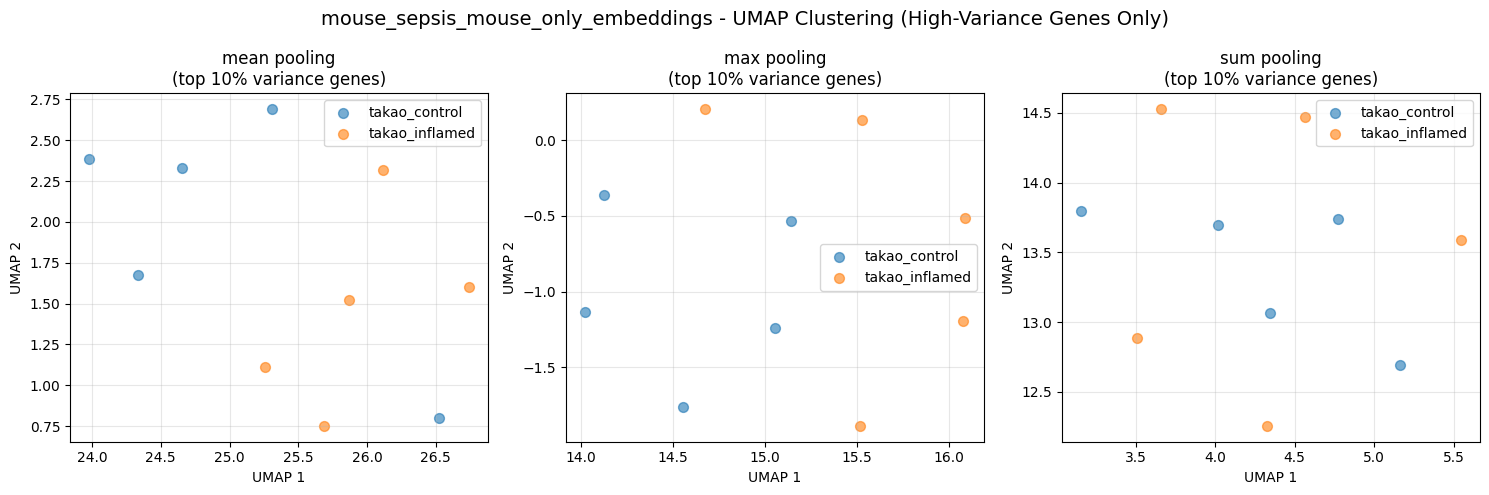


  Dataset: mouse_trauma_mouse_only_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0154 - 0.2221


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


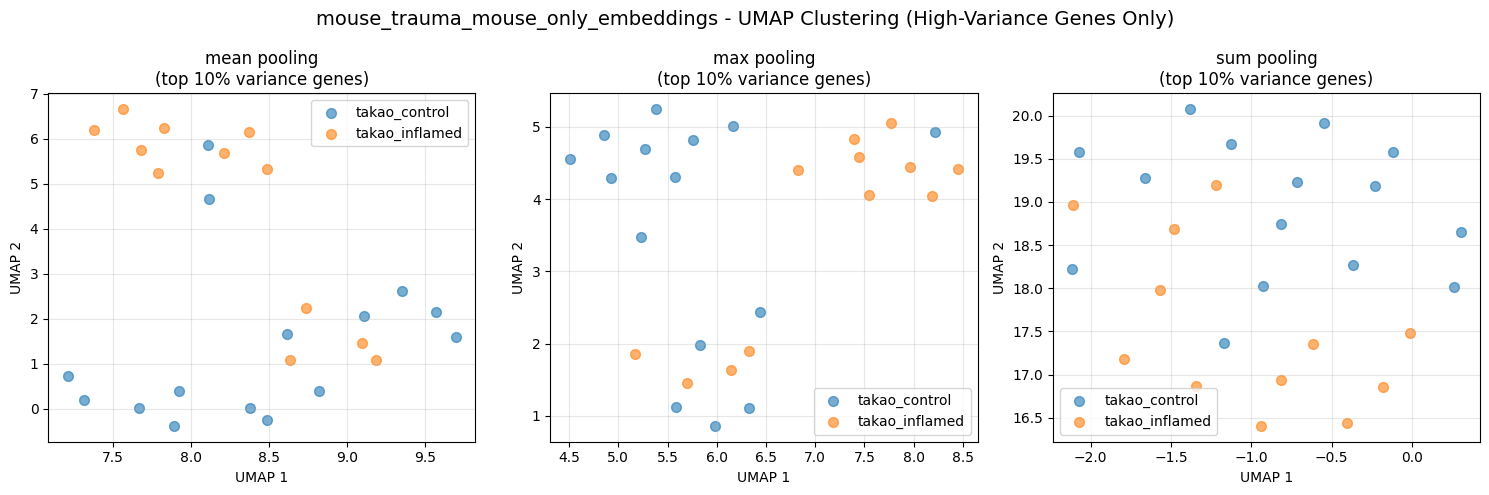


UMAP Clustering (High-Variance Genes Only): human_ortholog_filtered

  Dataset: human_burn_human_ortholog_filtered_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0169 - 0.3189


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


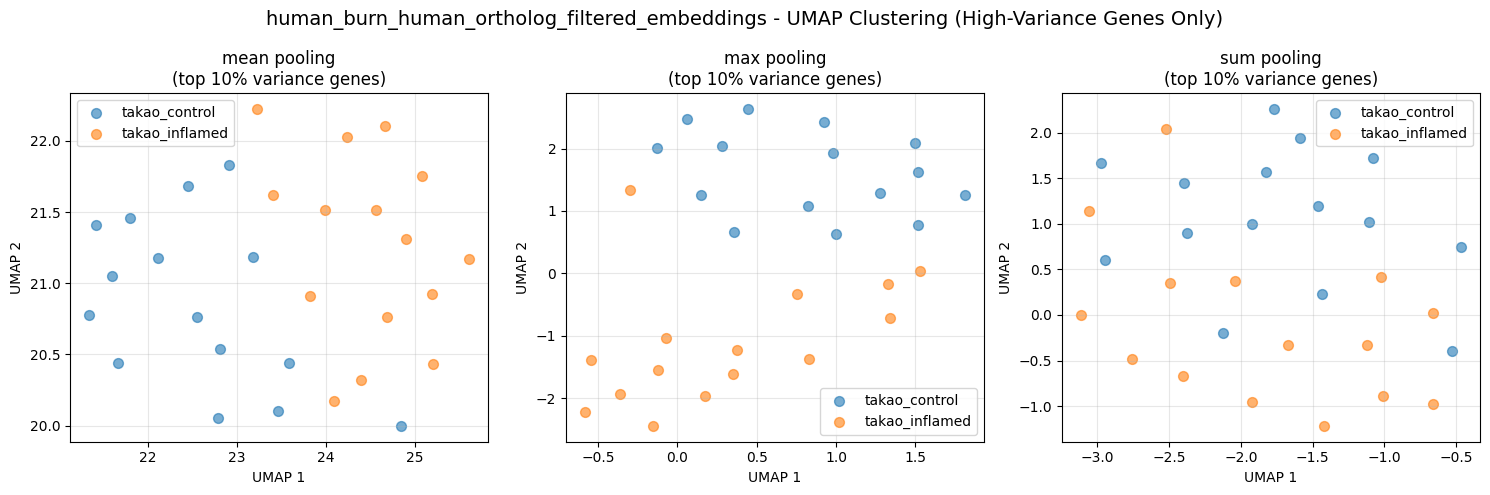


  Dataset: human_sepsis_human_ortholog_filtered_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0135 - 0.2852


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


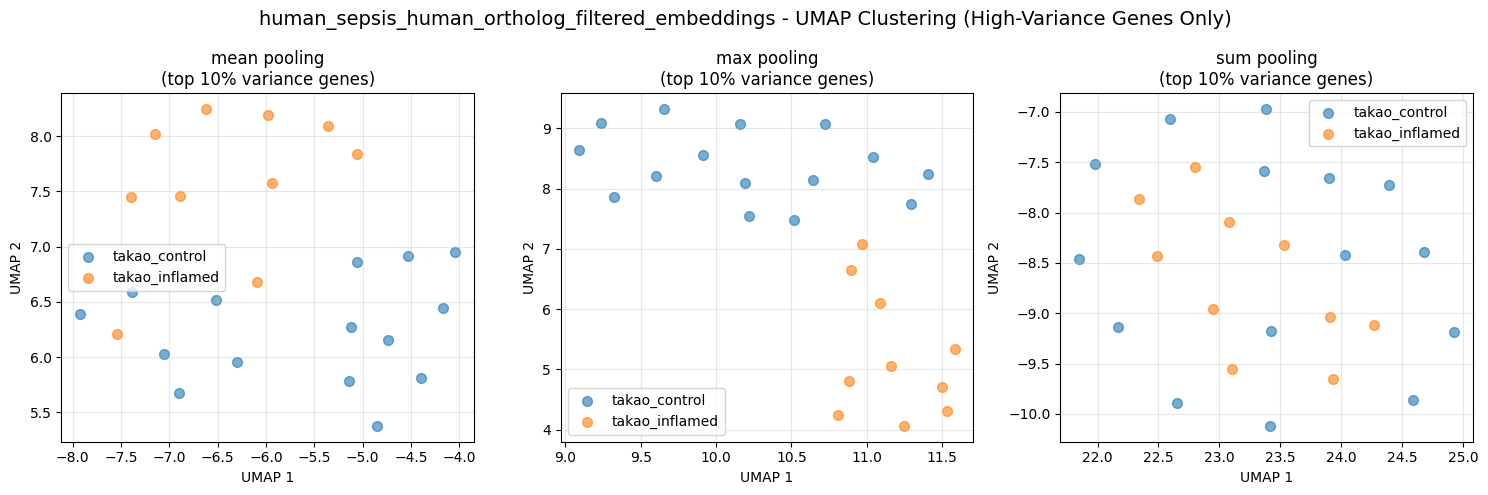


  Dataset: human_trauma_human_ortholog_filtered_embeddings
    Original genes: 20010
    Keeping top 2001 genes (10.0%)
    Variance range (kept): 0.0141 - 0.3325


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


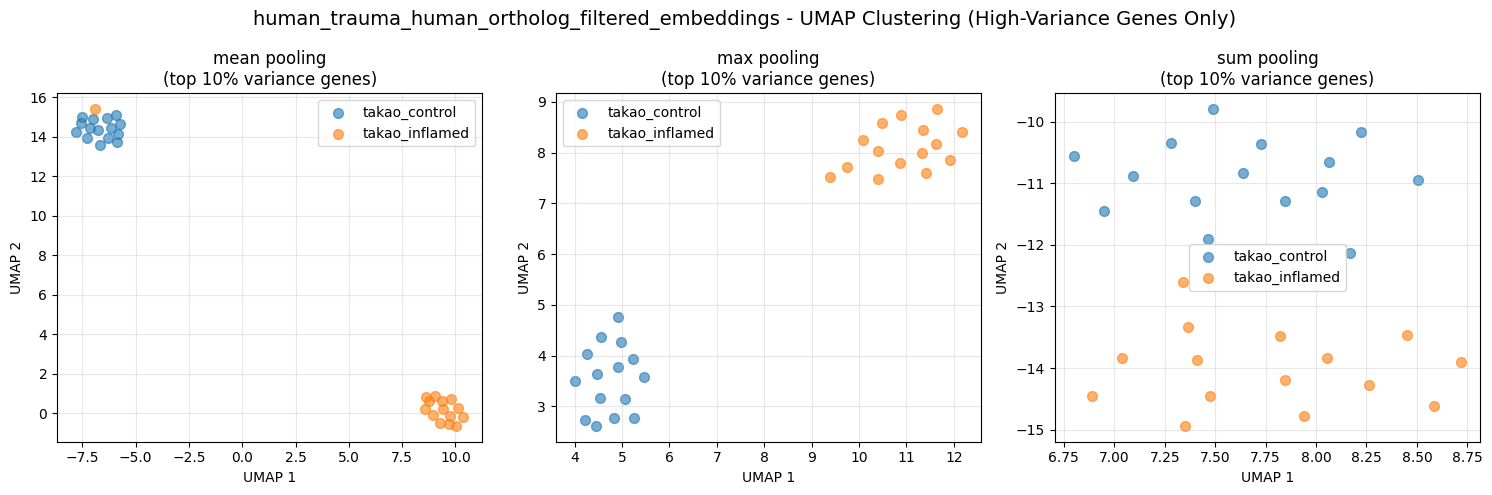

In [20]:
try:
    import umap
    
    # Filter to top 10% variance genes and repeat UMAP visualization
    for config_name, config_pooling in pooling_results.items():
        print(f"\n{'='*60}")
        print(f"UMAP Clustering (High-Variance Genes Only): {config_name}")
        print(f"{'='*60}")
        
        for dataset_name, data in config_pooling.items():
            # Get original embeddings and variance results
            original_emb = data["original"]
            var_per_gene = variance_results[config_name][dataset_name]["var_per_gene"]
            
            # Only proceed if we have 3D embeddings (n_samples, n_genes, embedding_dim)
            if len(original_emb.shape) == 3:
                n_samples, n_genes, emb_dim = original_emb.shape
                
                # Find top 10% variance genes (keep highest variance, drop lowest 90%)
                n_keep = max(1, int(n_genes * 0.1))  # Keep top 10%
                top_var_indices = np.argsort(var_per_gene)[-n_keep:]
                top_var_indices = np.sort(top_var_indices)  # Keep sorted for consistency
                
                print(f"\n  Dataset: {dataset_name}")
                print(f"    Original genes: {n_genes}")
                print(f"    Keeping top {n_keep} genes ({n_keep/n_genes*100:.1f}%)")
                print(f"    Variance range (kept): {var_per_gene[top_var_indices].min():.4f} - {var_per_gene[top_var_indices].max():.4f}")
                
                # Filter embeddings to keep only high-variance genes
                filtered_emb = original_emb[:, top_var_indices, :]
                
                # Apply pooling strategies to filtered embeddings
                filtered_pooled = apply_pooling_strategies(filtered_emb)
                
                # Get metadata for labels
                metadata = embeddings_data[config_name][dataset_name]["metadata"]
                if metadata is not None:
                    status_cols = ["takao_status", "status", "condition", "group"]
                    status_col = None
                    for col in status_cols:
                        if col in metadata.columns:
                            status_col = col
                            break
                    
                    if status_col:
                        labels = metadata[status_col].values
                    else:
                        labels = None
                else:
                    labels = None
                
                # Plot UMAP for each pooling strategy on filtered embeddings
                n_strategies = len([s for s in filtered_pooled.keys() if len(filtered_pooled[s].shape) == 2])
                fig, axes = plt.subplots(1, n_strategies, figsize=(5*n_strategies, 5))
                if n_strategies == 1:
                    axes = [axes]
                
                ax_idx = 0
                for strategy, pooled_emb in filtered_pooled.items():
                    if len(pooled_emb.shape) == 2 and pooled_emb.shape[1] > 2:
                        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(pooled_emb)-1))
                        embedding_2d = reducer.fit_transform(pooled_emb)
                        
                        ax = axes[ax_idx]
                        if labels is not None:
                            unique_labels = np.unique(labels)
                            for label in unique_labels:
                                mask = labels == label
                                ax.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                                         label=str(label), alpha=0.6, s=50)
                            ax.legend()
                        else:
                            ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.6, s=50)
                        
                        ax.set_xlabel("UMAP 1")
                        ax.set_ylabel("UMAP 2")
                        ax.set_title(f"{strategy} pooling\n(top 10% variance genes)")
                        ax.grid(True, alpha=0.3)
                        ax_idx += 1
                
                plt.suptitle(f"{dataset_name} - UMAP Clustering (High-Variance Genes Only)", fontsize=14)
                plt.tight_layout()
                plt.show()
            else:
                print(f"\n  Dataset: {dataset_name}")
                print(f"    Skipping: embeddings are already 2D (shape: {original_emb.shape})")
                print(f"    Cannot filter genes on already-pooled embeddings")
    
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")


### Summary Statistics


In [21]:
# Create summary table comparing pooling strategies
summary_rows = []

for config_name, config_pooling in pooling_results.items():
    for dataset_name, data in config_pooling.items():
        original_shape = data["original"].shape
        
        for strategy, pooled_emb in data["pooled"].items():
            if len(pooled_emb.shape) == 2:
                # Compute statistics
                pca_res = compute_pca_variance(pooled_emb, n_components=10)
                
                summary_rows.append({
                    "config": config_name,
                    "dataset": dataset_name,
                    "strategy": strategy,
                    "original_shape": str(original_shape),
                    "pooled_shape": str(pooled_emb.shape),
                    "mean": np.mean(pooled_emb),
                    "std": np.std(pooled_emb),
                    "pca_variance_1pc": pca_res["explained_variance_ratio"][0] if len(pca_res["explained_variance_ratio"]) > 0 else np.nan,
                    "pca_variance_10pc": pca_res["cumulative_variance"][9] if len(pca_res["cumulative_variance"]) > 9 else np.nan,
                })

summary_df = pd.DataFrame(summary_rows)
print("Summary Statistics for Pooling Strategies:")
print("="*80)
print(summary_df.to_string(index=False))


Summary Statistics for Pooling Strategies:
                 config                                         dataset strategy   original_shape pooled_shape     mean          std  pca_variance_1pc  pca_variance_10pc
             human_only                human_burn_human_only_embeddings     mean (30, 20010, 640)    (30, 640) 0.000090     0.826658          0.312296           0.985884
             human_only                human_burn_human_only_embeddings      max (30, 20010, 640)    (30, 640) 1.568432     0.846050          0.278918           0.916950
             human_only                human_burn_human_only_embeddings      sum (30, 20010, 640)    (30, 640) 1.807339 16541.419922          0.312296           0.985884
             human_only              human_sepsis_human_only_embeddings     mean (25, 20010, 640)    (25, 640) 0.000095     0.831229          0.393092           0.984874
             human_only              human_sepsis_human_only_embeddings      max (25, 20010, 640)    (25, 6

### Combined UMAP: Human and Mouse Together


In [22]:
# Combine human_only and mouse_only embeddings for cross-species UMAP visualization
print("="*60)
print("Combined UMAP: Human and Mouse Together")
print("="*60)

# Initialize variables
human_combined = None
mouse_combined = None
human_datasets = []
mouse_datasets = []

# Check that both configs exist
if "human_only" not in pooling_results or "mouse_only" not in pooling_results:
    print("Error: Both 'human_only' and 'mouse_only' configs must be available")
else:
    # Collect all embeddings from both configs
    human_embeddings = []
    mouse_embeddings = []
    
    # Collect human embeddings
    for dataset_name, data in pooling_results["human_only"].items():
        if len(data["original"].shape) == 3:
            human_embeddings.append(data["original"])
            human_datasets.append(dataset_name)
    
    # Collect mouse embeddings
    for dataset_name, data in pooling_results["mouse_only"].items():
        if len(data["original"].shape) == 3:
            mouse_embeddings.append(data["original"])
            mouse_datasets.append(dataset_name)
    
    if len(human_embeddings) == 0 or len(mouse_embeddings) == 0:
        print("Error: No 3D embeddings found in one or both configs")
    else:
        # Concatenate all human datasets
        human_combined = np.concatenate(human_embeddings, axis=0)
        # Concatenate all mouse datasets
        mouse_combined = np.concatenate(mouse_embeddings, axis=0)
        
        print(f"\nHuman combined shape: {human_combined.shape}")
        print(f"Mouse combined shape: {mouse_combined.shape}")
        
        # Check gene dimension match
        if human_combined.shape[1] != mouse_combined.shape[1]:
            print(f"Warning: Gene dimension mismatch ({human_combined.shape[1]} vs {mouse_combined.shape[1]})")
            print("Using minimum gene dimension")
            min_genes = min(human_combined.shape[1], mouse_combined.shape[1])
            human_combined = human_combined[:, :min_genes, :]
            mouse_combined = mouse_combined[:, :min_genes, :]
        
        print(f"After alignment - Human: {human_combined.shape}, Mouse: {mouse_combined.shape}")


Combined UMAP: Human and Mouse Together

Human combined shape: (85, 20010, 640)
Mouse combined shape: (85, 20010, 640)
After alignment - Human: (85, 20010, 640), Mouse: (85, 20010, 640)


In [23]:
# Compute combined variance across ALL human and mouse datasets
print("\n" + "="*60)
print("Computing Combined Variance (Human + Mouse)")
print("="*60)

top_var_indices = None

if human_combined is not None and mouse_combined is not None:
    # Collect variance from all human datasets
    human_var_list = []
    for dataset_name in human_datasets:
        if dataset_name in variance_results["human_only"]:
            var_per_gene = variance_results["human_only"][dataset_name]["var_per_gene"]
            # Ensure same length
            if len(var_per_gene) == human_combined.shape[1]:
                human_var_list.append(var_per_gene)
            else:
                var_per_gene = var_per_gene[:human_combined.shape[1]]
                human_var_list.append(var_per_gene)

    # Collect variance from all mouse datasets
    mouse_var_list = []
    for dataset_name in mouse_datasets:
        if dataset_name in variance_results["mouse_only"]:
            var_per_gene = variance_results["mouse_only"][dataset_name]["var_per_gene"]
            # Ensure same length
            if len(var_per_gene) == mouse_combined.shape[1]:
                mouse_var_list.append(var_per_gene)
            else:
                var_per_gene = var_per_gene[:mouse_combined.shape[1]]
                mouse_var_list.append(var_per_gene)

    # Combine all variances (human + mouse)
    all_combined_var = human_var_list + mouse_var_list

    if len(all_combined_var) > 0:
        # Compute mean variance across all datasets
        combined_var = np.mean(np.array(all_combined_var), axis=0)
        n_genes = len(combined_var)
        
        # Find top 10% variance genes
        n_keep = max(1, int(n_genes * 0.1))
        top_var_indices = np.argsort(combined_var)[-n_keep:]
        top_var_indices = np.sort(top_var_indices)
        
        print(f"Total datasets: {len(all_combined_var)} (human: {len(human_var_list)}, mouse: {len(mouse_var_list)})")
        print(f"Total genes: {n_genes}")
        print(f"Top {n_keep} genes ({n_keep/n_genes*100:.1f}%)")
        print(f"Variance range (kept): {combined_var[top_var_indices].min():.4f} - {combined_var[top_var_indices].max():.4f}")
    else:
        print("Warning: Could not compute combined variance")
else:
    print("Skipping: human_combined or mouse_combined not available")



Computing Combined Variance (Human + Mouse)
Total datasets: 7 (human: 3, mouse: 4)
Total genes: 20010
Top 2001 genes (10.0%)
Variance range (kept): 0.0127 - 0.1863



Creating Combined UMAP Visualizations

  mean pooling + all_genes
    Combined shape: (170, 640)


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  mean pooling + top10pct_variance
    Combined shape: (170, 640)


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  max pooling + all_genes
    Combined shape: (170, 640)


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  max pooling + top10pct_variance
    Combined shape: (170, 640)


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  sum pooling + all_genes
    Combined shape: (170, 640)


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  sum pooling + top10pct_variance
    Combined shape: (170, 640)


/home/amoneim/inflamm-debate-fm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


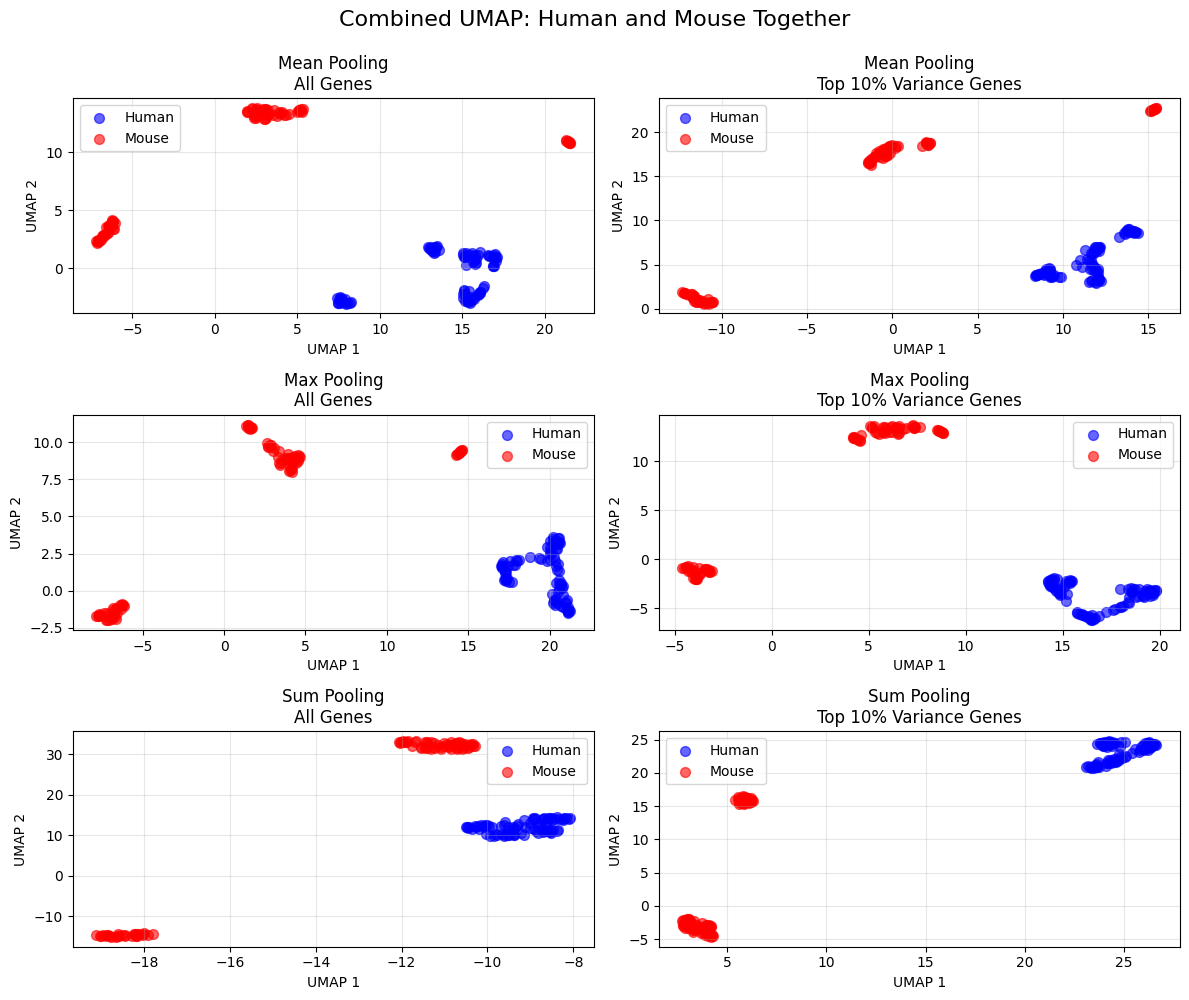


Combined UMAP visualization complete!


In [24]:
# Create combined UMAPs for all genes and high-variance genes
print("\n" + "="*60)
print("Creating Combined UMAP Visualizations")
print("="*60)

if human_combined is not None and mouse_combined is not None:
    # Pooling strategies to visualize
    strategies = ["mean", "max", "sum"]
    gene_filters = ["all_genes", "top10pct_variance"]
    
    # Create labels for human vs mouse
    human_labels = np.array(["Human"] * human_combined.shape[0])
    mouse_labels = np.array(["Mouse"] * mouse_combined.shape[0])
    combined_labels = np.concatenate([human_labels, mouse_labels])
    
    fig, axes = plt.subplots(len(strategies), len(gene_filters), figsize=(12, 10))
    if len(strategies) == 1:
        axes = axes.reshape(1, -1)
    if len(gene_filters) == 1:
        axes = axes.reshape(-1, 1)
    
    for strategy_idx, strategy in enumerate(strategies):
        for filter_idx, gene_filter in enumerate(gene_filters):
            ax = axes[strategy_idx, filter_idx]
            
            # Filter genes if needed
            if gene_filter == "all_genes":
                human_emb = human_combined
                mouse_emb = mouse_combined
                filter_label = "All Genes"
            else:  # top10pct_variance
                if top_var_indices is not None:
                    human_emb = human_combined[:, top_var_indices, :]
                    mouse_emb = mouse_combined[:, top_var_indices, :]
                    filter_label = "Top 10% Variance Genes"
                else:
                    print(f"  Skipping {strategy} + {gene_filter}: No variance indices")
                    ax.text(0.5, 0.5, "No variance data", ha="center", va="center")
                    continue
            
            # Apply pooling strategy
            if strategy == "mean":
                human_pooled = mean_pooling(human_emb)
                mouse_pooled = mean_pooling(mouse_emb)
            elif strategy == "max":
                human_pooled = max_pooling(human_emb)
                mouse_pooled = max_pooling(mouse_emb)
            else:  # sum
                human_pooled = sum_pooling(human_emb)
                mouse_pooled = sum_pooling(mouse_emb)
            
            # Combine human and mouse
            combined_pooled = np.concatenate([human_pooled, mouse_pooled], axis=0)
            
            print(f"\n  {strategy} pooling + {gene_filter}")
            print(f"    Combined shape: {combined_pooled.shape}")
            
            # Compute UMAP
            reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(combined_pooled)-1))
            embedding_2d = reducer.fit_transform(combined_pooled)
            
            # Plot with human/mouse distinction
            human_mask = combined_labels == "Human"
            mouse_mask = combined_labels == "Mouse"
            
            ax.scatter(embedding_2d[human_mask, 0], embedding_2d[human_mask, 1], 
                      label="Human", alpha=0.6, s=50, color="blue")
            ax.scatter(embedding_2d[mouse_mask, 0], embedding_2d[mouse_mask, 1], 
                      label="Mouse", alpha=0.6, s=50, color="red")
            
            ax.set_xlabel("UMAP 1")
            ax.set_ylabel("UMAP 2")
            ax.set_title(f"{strategy.capitalize()} Pooling\n{filter_label}")
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("Combined UMAP: Human and Mouse Together", fontsize=16, y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("Combined UMAP visualization complete!")
    print("="*60)
else:
    print("Error: Cannot create combined UMAPs - human_combined or mouse_combined not available")
